In [4]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import coo_matrix, csc_matrix, linalg as LA
import time

# 1. Construction the matrix X

In [5]:
def construct_X(M, angles, Np=None):
    """
    Construct weight matrix for image dimensions MxM,
    angles: Array of sensor angles
    Np: number of sensors
    
    Indice names:
    i_p : sensor index
    i_o : angle/orientation index
    i = i_p + Np * i_o  : response index
    a, b : image coordinates
    j = a + M * b   : flattened image coordinates
    """
    if Np is None:
        Np = int(np.ceil(np.sqrt(2) * M))
        if Np % 2 == 0:
            Np += 1
    # index boundaries
    D = M**2
    No = len(angles)
    N = No * Np
    
    # coordinate matrix: coordinates of all pixel centers
    # as column vectors
    C = np.mgrid[M-1:-1:-1, :M:1].astype(np.float64).reshape(2, -1)
    center = M / 2
    C += 0.5 - center
        
    # convert angles from degrees to radians
    angles = np.unwrap(np.deg2rad(angles))
    
    # matrix of normal vectors for sensor positions
    n = np.column_stack([np.sin(angles), np.cos(angles)])
    
    # position of sensor 0 to sensor coordinate system
    s0 = Np / 2 - 0.5
    
    # projections of pixel onto sensor
    # first dim: angles, 2. dim: j
    p = np.dot(n, C) + s0
    
    # lists for building of sparse matrix
    weights, i_ind, j_ind = [], [], []
    
    # find weights for every angle
    for i_o, pixels in enumerate(p):
        # find left sensor for pixels
        pixel_floor = np.floor(pixels).astype(int)
        # find weight for right sensor
        alpha = pixels - pixel_floor
        # indices, weights for left and right sensor
        sensor_ind = np.concatenate((pixel_floor, pixel_floor+1))
        weight = np.concatenate((1-alpha, alpha))
        # filter indices out of range
        mask = np.logical_and(sensor_ind >= 0, sensor_ind < Np)
        
        weights += list(weight[mask])
        i_ind += list(sensor_ind[mask] + i_o * Np)
        j_ind += list(np.nonzero(mask)[0] % D)
    
    # construct sparse matrix convert to csc-matrix for solving
    return coo_matrix((weights, (i_ind, j_ind)), shape=(N, D), dtype=np.float32).asformat('csc')

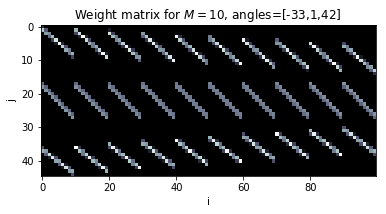

In [7]:
# Test function with example given on sheet
X = construct_X(10, [-33, 1, 42])
X_dense = X.todense()
plt.imshow(X_dense, cmap='bone')
plt.ylabel('j'); plt.xlabel('i')
plt.title('Weight matrix for $M=10$, angles=[-33,1,42]')
# check if computed matrix is equal to example
X_ex = np.load('hs_tomography/X_example.npy')
assert(np.array_equal(X_ex, X_dense))

# 2. Recovering the image

In [8]:
def image(alphas, response, M, Np, tol=1e-4, verbose=True):
    "Recover image and measure time"
    if verbose:
        print(f"Recovering image with M={M}, Np={Np}, No={len(alphas)}, tolerance={tol}")
    t0 = time.time()
    # construct weight matrix
    X = construct_X(M, alphas, Np)
    t1 = time.time()
    if verbose:
        print(f"Sparsity of X: {X.nnz / np.product(X.shape)}, Time to construct X: {t1-t0:.2f}s")
    # find least squares solution
    beta = LA.lsqr(X, response, atol=tol, btol=tol)[0]
    t2 = time.time()
    if verbose:
        print(f"Solved for image in {t2-t1:.2f}s with tolerance {tol}, total time {t2-t0:.2f}s")
    return beta.reshape(M,M)

In [9]:
# Reconstruction of the low quality image
alphas = np.load('hs_tomography/alphas_77.npy')
response = np.load('hs_tomography/y_77.npy')
beta77 = image(alphas, response, tol=1e-6, M=77, Np=109)

Recovering image with M=77, Np=109, No=90, tolerance=1e-06
Sparsity of X: 0.01834862385321101, Time to construct X: 0.38s
Solved for image in 1.97s with tolerance 1e-06, total time 2.35


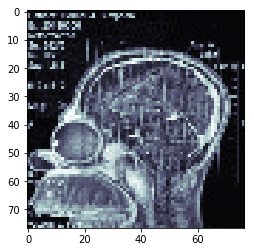

In [10]:
fig, ax = plt.subplots(figsize=(4,4))
ax.imshow(beta77, cmap='bone');

In [14]:
# Reconstruction of the high quality image
alphas = np.load('hs_tomography/alphas_195.npy')
response = np.load('hs_tomography/y_195.npy')
beta195 = image(alphas, response, tol=1e-7, M=195, Np=275)

Recovering image with M=195, Np=275, No=179, tolerance=1e-07
Sparsity of X: 0.007272716587714439, Time to construct X: 4.82s
Solved for image in 282.52s with tolerance 1e-07, total time 287.34


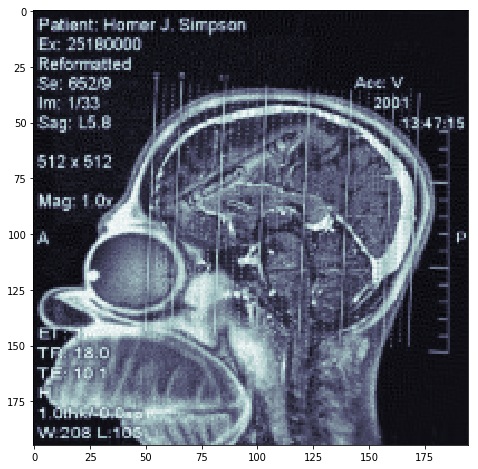

In [15]:
fig, ax = plt.subplots(figsize=(8,8))
ax.imshow(beta195, cmap='bone');

As we can see in the ct scan, H.S. has a long thin object in his forehead, maybe a pen or a nerf dart.

# 3. Minimizing the radiation dose

In [17]:
# calculate images with subsets of angles
images = []
for i in range(9):
    images.append(image(alphas[::i+1], response.reshape(-1, 275)[::i+1].reshape(-1), 195, 275))

Recovering image with M=195, Np=275, No=179, tolerance=0.0001
Sparsity of X: 0.007272716587714439, Time to construct X: 4.95s
Solved for image in 3.41s with tolerance 0.0001, total time 8.37
Recovering image with M=195, Np=275, No=90, tolerance=0.0001
Sparsity of X: 0.007272718772205952, Time to construct X: 2.34s
Solved for image in 1.33s with tolerance 0.0001, total time 3.66
Recovering image with M=195, Np=275, No=60, tolerance=0.0001
Sparsity of X: 0.0072727208973362815, Time to construct X: 1.57s
Solved for image in 0.82s with tolerance 0.0001, total time 2.38
Recovering image with M=195, Np=275, No=45, tolerance=0.0001
Sparsity of X: 0.007272718772205952, Time to construct X: 1.18s
Solved for image in 0.60s with tolerance 0.0001, total time 1.78
Recovering image with M=195, Np=275, No=36, tolerance=0.0001
Sparsity of X: 0.007272716647075622, Time to construct X: 0.95s
Solved for image in 0.45s with tolerance 0.0001, total time 1.40
Recovering image with M=195, Np=275, No=30, tole

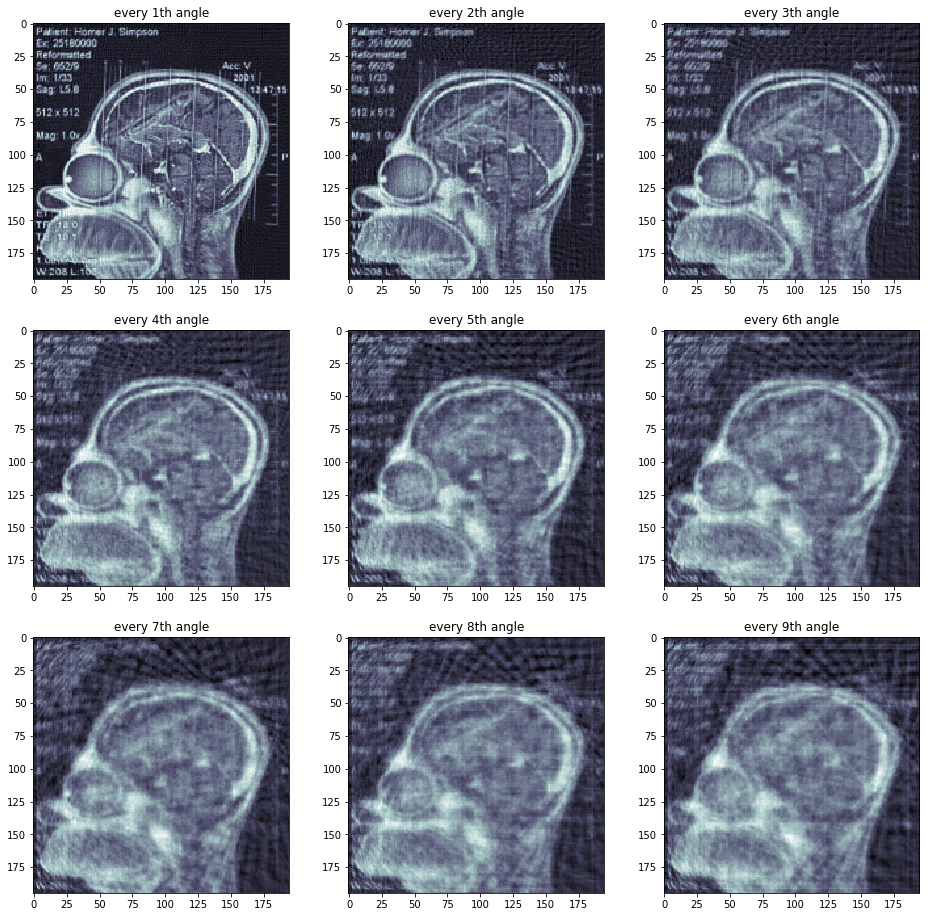

In [91]:
fig, axes = plt.subplots(3,3, figsize=(16,16))
for i, (img, ax) in enumerate(zip(images, axes.flatten())):
    ax.imshow(img, cmap='bone')
    ax.set_title(f"every {i+1}th angle")

As we can see from the images, the outline of the head can be seen even with a 9th of the angles (equally spaced between $-90^{\circ}$ and $90^{\circ}$.  
The foreign object in the head is visible with angle steps of $\leq4^{\circ}$, but only clearly with steps $\leq3^{\circ}$. So we can reduce the radiation dose by a factor of 3 and nonetheless find the object.

If we limit the angle to a $90\leq$ radius, we see much less detail in the whole image, but our foreign object is visible. This is only because of it's specific orientation, and it would not be reliable to use, but a measure at first to get an overview.

In [ ]:
fig, ax = plt.subplots(figsize=(7,7))
img1 = image(alphas[:90], response.reshape(-1, Np)[:90].reshape(-1), 195, 275)
ax.imshow(img1, cmap='bone')